In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=15

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

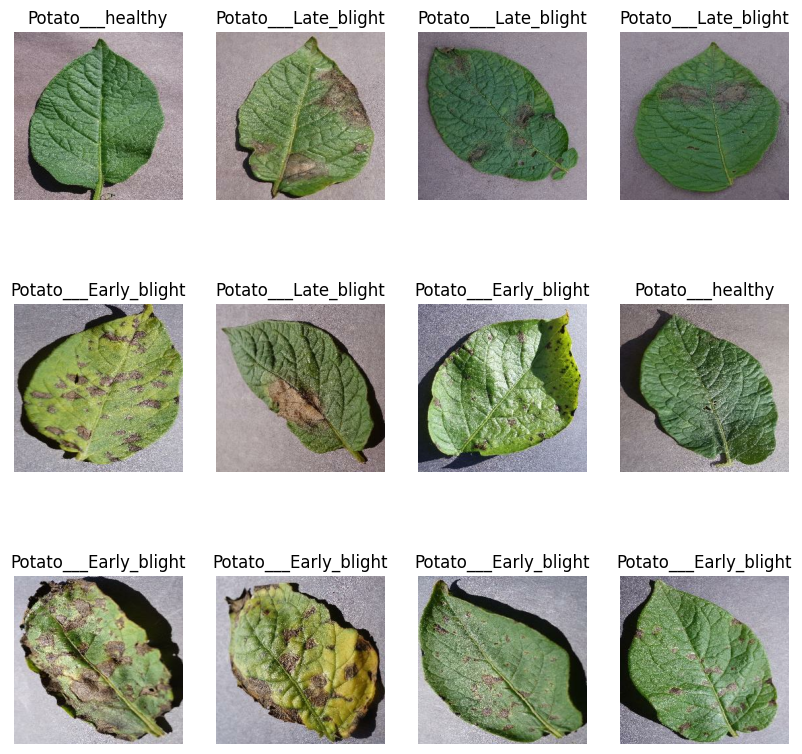

In [5]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1): 
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [6]:
len(dataset)
#since our dataset is divided into batchsize of 32so if we do 68*32=2176 which is equal to toal images.the last batch is not perfect so its showing more that our total images


68

<h5>
The dataset needs to be divided into three distinct subsets for different purposes:

1. Training: This portion of the dataset will be utilized during the training phase.
2. Validation: It will serve as a benchmark for testing and validation during the training process.
3. Test: This segment will be reserved for post-training testing, allowing us to evaluate the model's performance.
</h6>

In [7]:
def set_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split)==1
    ds_size=len(ds)

    if(shuffle):
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [8]:
train_ds,val_ds,test_ds=set_partition_tf(dataset)

In [9]:
print("Length of Training Dataset:", len(train_ds))
print("Length of Testing Dataset:", len(test_ds))
print("Length of Validation Dataset:", len(val_ds))

Length of Training Dataset: 54
Length of Testing Dataset: 8
Length of Validation Dataset: 6


### Cache, Shuffle, and Prefetch the Dataset

In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<h3>Building the Model</h3>

### Creating a Layer for Resizing and Normalization
To ensure our images are properly prepared for input into the neural network, we must perform two key operations: resizing and normalization. Resizing is essential to adapt the images to the desired dimensions. Additionally, we need to normalize the pixel values for improved model performance, which involves scaling them to a range between 0 and 1 by dividing by 256.

These operations should be applied consistently during both the training and inference phases. Therefore, we can include them as a dedicated layer within our Sequential Model.

You might wonder why we need to resize an image from (256,256) to (256,256). The reason is that this layer becomes valuable when we transition from training to using the model for predictions. At that point, someone might provide an image with different dimensions than (256,256), and this layer will handle the resizing process.

In [11]:
rescaling_and_resizing=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

### Data Augmentation

Data augmentation is employed when we have a limited dataset, and its purpose is to enhance our model's accuracy by increasing the effective size of the dataset through various transformations and modifications.

In [12]:
data_augument=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
#Applying Data Augumentation to Train Dataset
train_ds=train_ds.map(
    lambda x,y: (data_augument(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We employ a Convolutional Neural Network (CNN) in conjunction with a Softmax activation function in the output layer. Additionally, we incorporate initial layers to handle resizing, normalization, and data augmentation.

In [14]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    rescaling_and_resizing,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15
)

Epoch 1/15
54/54 [==============================] - 97s 2s/step - loss: 0.9120 - accuracy: 0.4780 - val_loss: 0.8469 - val_accuracy: 0.5729
Epoch 2/15
54/54 [==============================] - 108s 2s/step - loss: 0.7229 - accuracy: 0.6615 - val_loss: 0.5162 - val_accuracy: 0.8073
Epoch 3/15
54/54 [==============================] - 97s 2s/step - loss: 0.4166 - accuracy: 0.8299 - val_loss: 0.3949 - val_accuracy: 0.8438
Epoch 4/15
54/54 [==============================] - 96s 2s/step - loss: 0.3589 - accuracy: 0.8524 - val_loss: 0.3065 - val_accuracy: 0.8542
Epoch 5/15
54/54 [==============================] - 105s 2s/step - loss: 0.2762 - accuracy: 0.8900 - val_loss: 0.2888 - val_accuracy: 0.8542
Epoch 6/15
54/54 [==============================] - 85s 2s/step - loss: 0.2425 - accuracy: 0.9028 - val_loss: 0.2645 - val_accuracy: 0.8698
Epoch 7/15
54/54 [==============================] - 80s 1s/step - loss: 0.2508 - accuracy: 0.9062 - val_loss: 0.2628 - val_accuracy: 0.8906
Epoch 8/15
54/54 [

In [16]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 351ms/step - loss: 0.3734 - accuracy: 0.8555


In [17]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [19]:
print(len(history.history['loss']))
print(history.history['loss'][:5] )# show loss for first 5 epochs)

15
[0.9119622111320496, 0.722896158695221, 0.4166390001773834, 0.3588838279247284, 0.27618250250816345]


In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

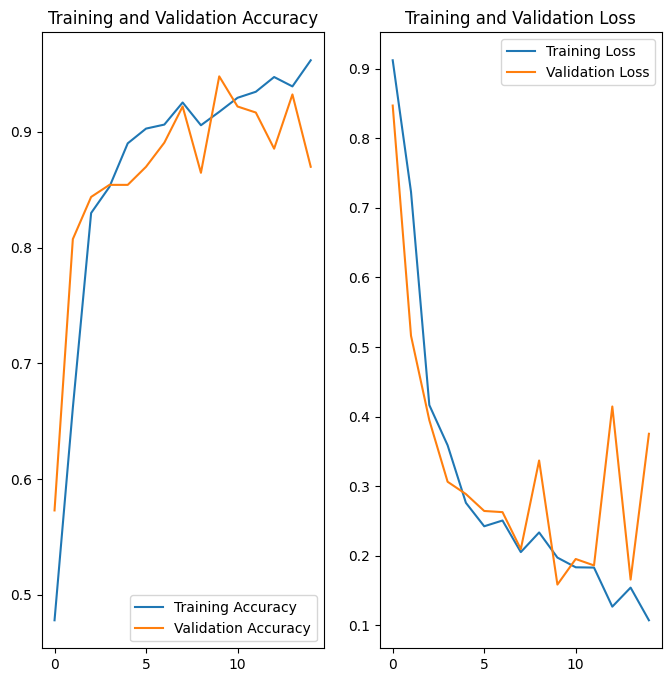

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 494ms/step
predicted label: Potato___Late_blight


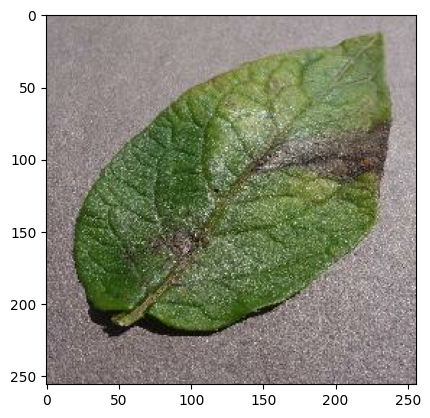

In [22]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [23]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


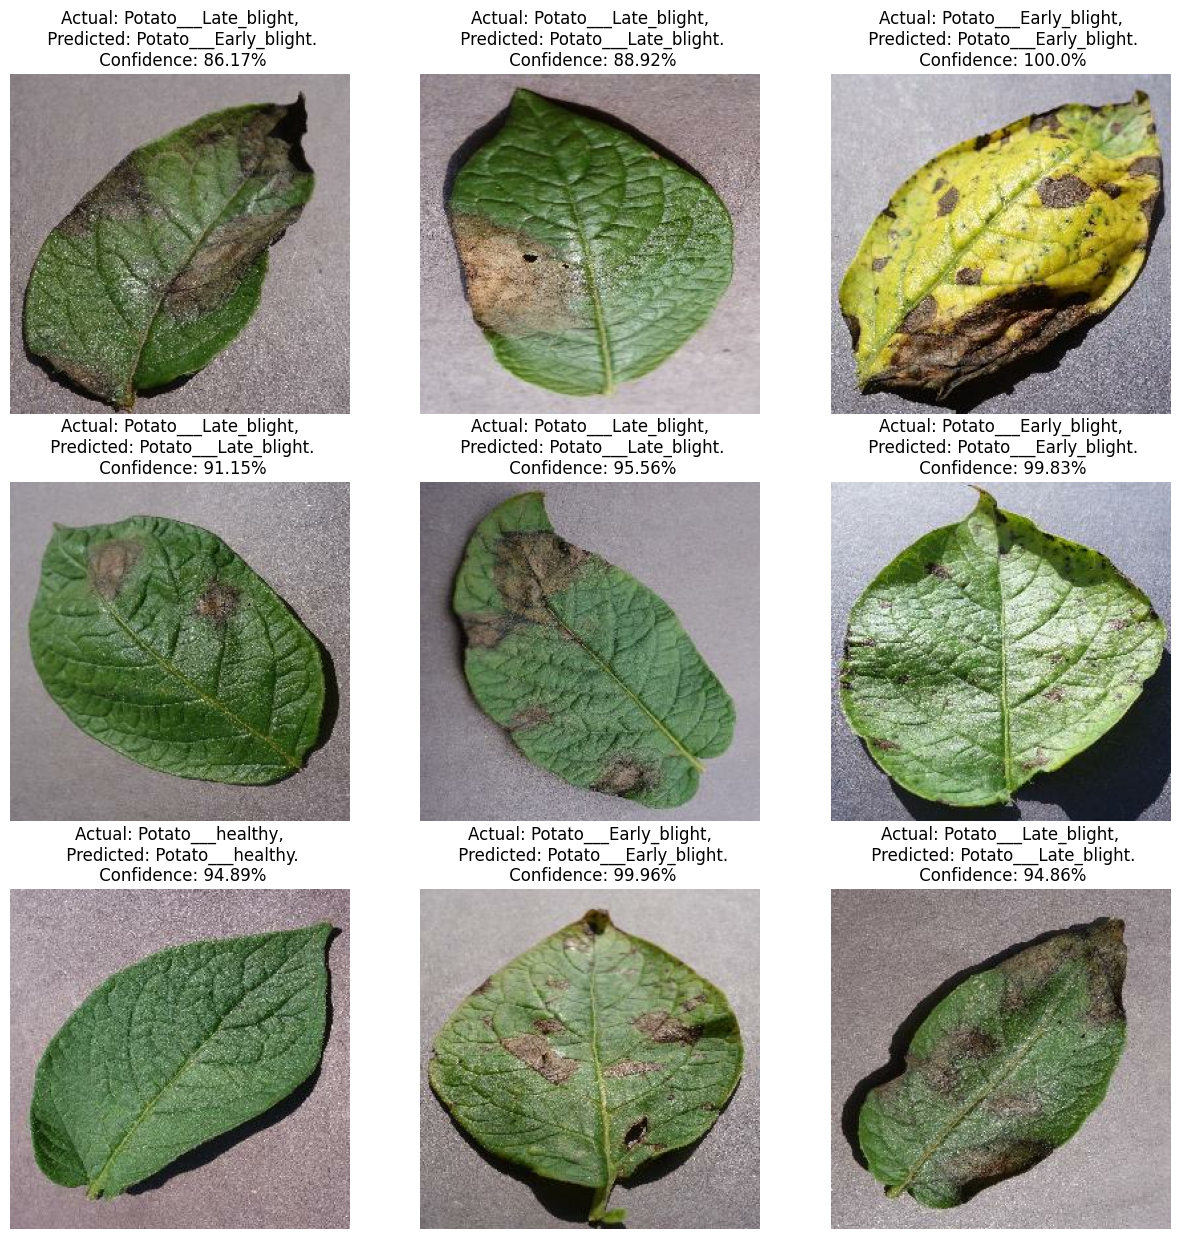

In [24]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [25]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [29]:
# model.save("../potatoes.h5")
model.save('model.keras')